In [155]:
import csv                                 # to parse the Etymological Wordnet CSV file
from collections import Counter            # to count things
from nltk import word_tokenize             # for breaking texts into words
from nltk.tokenize import RegexpTokenizer # for span tokenizing
from nltk.tag import pos_tag               # for detecting parts of speech
from nltk.stem import WordNetLemmatizer    # for getting dictionary forms of words
from string import punctuation             # for cleaning texts
from pycountry import languages            # to look up ISO language codes
from nltk.corpus import stopwords          # to remove unnecessary words
from nltk.corpus import wordnet
import pandas as pd                        # for pretty charts
import matplotlib                          # also for pretty charts
#matplotlib.style.use('ggplot')             # make the charts look nicer
import click                               # make it a command-line program
import codecs
import logging                             # to log messages
import re
from glob import glob
from pkg_resources import resource_filename
%matplotlib inline


"""

I made the file below, etymwn-smaller.tsv, by running these unix commands
on the Etymological Wordnet:

First, get only those entries with the relation "rel:etymology":
    grep "rel:etymology" etymwn.tsv > etymwn-small.tsv
Now we can remove the relation column, since it's all "rel:etymology":
    cat etymwn-small.tsv | cut -f1,3 > etymwn-smaller.tsv

"""

# Parse the CSV file.
etymdict = {}
etymwn = resource_filename(__name__, 'etymwn-smaller.tsv')
with open(etymwn) as csvfile:
    csvreader = csv.reader(csvfile, delimiter='\t')
    for line in csvreader:
        if line[0] in etymdict:
            etymdict[line[0]].append(line[1])
        else:
            etymdict[line[0]] = [line[1]]

In [211]:
class LangList():
    """
    A class for language lists, that helps to count languages.
    """
    def __init__(self, langs):
        self.langs = langs

    def __repr__(self):
        return str(self.langs)

    @property
    def stats(self):
        """ Generates statistics about languages present in the list. """
        counter = Counter(self.langs)
        stats = {}
        for lang in counter.keys():
            stats[lang] = (counter[lang] / len(self.langs))*100
        return stats

class Word():
    """
    A word object, for looking up etymologies of single words.
    """
    def __init__(self, word, lang='eng', ignoreAffixes=True, ignoreCurrent=True):
        self.lang = lang
        self.word = word
        self.ignoreAffixes = ignoreAffixes
        self.ignoreCurrent = ignoreCurrent

    def __repr__(self):
        return '%s (%s)' % (self.word, self.lang)

    def __str__(self):
        return self.word

    def oldVersions(self, language):
        """
        Returns a list of older versions of a language, such that given "eng"
        (Modern English) it will return "enm" (Middle English). This is used
        for filtering out current languages in the ignoreCurrent option of
        parents() below.
        """
        if language == 'eng':
            return ['enm']
        if language == 'fra':
            return ['frm', 'xno'] # Middle French
        if language == 'dut':
            return ['dum'] # Middle Dutch
        if language == 'gle': # Irish
            return ['mga'] # Middle Irish
        # TODO: add other languages here.
        else:
            return []

    @property
    def parents(self):
        """
        The main etymological lookup method.

        ignoreAffixes will remove suffixes like -ly, so that the parent list
        for "universally" returns "universal (eng)" instead of "universal
        (eng), -ly (eng)."

        ignoreCurrent will ignore etymologies in the current language and
        slightly older versions of that language, so that it skips "universal
        (eng)," and goes straight to the good stuff, i.e. "universalis (lat)."
        Given a word in English, it will skip all other English and Middle
        English ancestors, but won't skip Old English.
        """
        ignoreAffixes = self.ignoreAffixes
        ignoreCurrent = self.ignoreCurrent
        word = self.word
        language = self.lang

        # Finds the first-generation ancestor(s) of a word.
        try:
            rawParentList = etymdict[language + ": " + word]
        except:
            rawParentList = []
        parentList = [self.split(parent) for parent in rawParentList]
        if ignoreAffixes:
            parentList = [p for p in parentList if p.word[0] is not '-']
            parentList = [p for p in parentList if p.word[-1] is not '-']
        if ignoreCurrent:
            newParents = []
            for parent in parentList:
                if parent.lang == language or parent.lang in self.oldVersions(language):
                    logging.debug('Searching deeper for word %s with lang %s' % (parent.word, parent.lang))
                    for otherParent in parent.parents: # Go deeper.
                        newParents.append(otherParent)
                else:
                    newParents.append(parent)
            parentList = newParents
        return parentList

    @property
    def parentLanguages(self):
        parentLangs = []
        for parent in self.parents:
            parentLangs.append(parent.lang)
        return LangList(parentLangs)

    @property
    def grandparents(self):
        return [Word(parent.word, lang=parent.lang).parents
        for parent in self.parents]

    @property
    def grandparentLanguages(self):
        grandparentLangs = []
        for grandparentList in self.grandparents:
            for grandparent in grandparentList:
                grandparentLangs.append(grandparent.lang)
        return LangList(grandparentLangs)

    def split(self, expression):
        """ Takes and expression in the form 'enm: not' and returns
        a Word object where word.lang is 'enm' and word.word is 'not'.
        """
        parts = expression.split(':')
        return Word(parts[1].strip(), parts[0])

class Text():
    def __init__(self, text, lang='eng', ignoreAffixes=True, ignoreCurrent=True):
        self.text = text
        self.lang = lang
        self.ignoreAffixes = ignoreAffixes
        self.ignoreCurrent = ignoreCurrent
        logging.debug('Initializing text with lang %s' % lang)
        if ignoreAffixes:
            logging.debug('Ignoring affixes.')
        if ignoreCurrent:
            logging.debug('Ignoring current language and its middle variants.')

    langDict = {'Germanic': ['eng', 'enm', 'ang', 'deu', 'dut', 'nld', 'dum',
                            'non', 'gml', 'yid', 'swe', 'rme', 'sco', 'isl',
                            'dan'],
                'Latinate': ['fra', 'frm', 'fro', 'lat', 'spa', 'xno', 'por',
                            'ita'],
                'Indo-Iranian': ['hin', 'fas'],
                'Celtic': ['gle', 'gla'],
                'Hellenic': ['grc'],
                'Semitic': ['ara', 'heb'],
                'Turkic': ['tur'],
                'Austronesian': ['tgl', 'mri', 'smo'],
                'Balto-Slavic': ['rus'],
                'Uralic': ['fin', 'hun'],
                'Japonic': ['jpn']}

    @property
    def tokens(self):
        return word_tokenize(self.text)

    # @property
    # def tokens(self):
    #     tokenizer = RegexpTokenizer("\b\w+['-]?\b")
    #     tokenizer = RegexpTokenizer(r"\b\w+['-]?\w+?\b")
    #     self.spans = tokenizer.word_tokenize(self.text)
    #     return tokenizer.tokenize(self.text)

    @property
    def cleanTokens(self, removeStopwords=True):
        clean = [token for token in self.tokens if token not in punctuation]
        clean = [token.lower() for token in clean]
        clean = [token for token in clean if token.isalpha()]
        if removeStopwords:
            clean = self.removeStopwords(clean)
        return clean

    def removeStopwords(self, tokens):
        availableStopwords = "danish english french hungarian norwegian"\
        "spanish turkish dutch finnish german italian portuguese russian"\
        "swedish".split()
        stopDict = {lang[:3]: lang for lang in availableStopwords}
        stopDict['fra'] = 'french' # Exception
        stopDict['deu'] = 'german' # Another exception
        if self.lang in stopDict:
            stops = stopwords.words(stopDict[self.lang])
            return [token for token in tokens if token not in stops]
        else:
            return tokens

    @property
    def types(self):
        return set(self.cleanTokens)

    @property
    def posTags(self):
        return pos_tag(self.types)

    @property
    def lemmas(self):
        # Don't try to lemmatize non-English texts.
        if self.lang != 'eng':
            return self.types
        wordnetLemmatizer = WordNetLemmatizer()
        lemmas = []
        for word, pos in self.posTags:
            pos = self.get_wordnet_pos(pos)
            if pos == '':
                pos = 'n'
            lemmas.append(wordnetLemmatizer.lemmatize(word, pos))
        return lemmas

    def get_wordnet_pos(self, treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return ''

    @property
    def wordObjects(self):
        return [Word(token, self.lang, ignoreAffixes=self.ignoreAffixes,
        ignoreCurrent=self.ignoreCurrent) for token in self.lemmas]

    @property
    def unknownWords(self): 
        return [w for w in self.wordObjects if w.parents == []]
    
    def annotate(self):
        """ Returns an annotated text in HTML format. """
        html = ""
        return html

    def showMacroEtym(self):
        for word in self.wordObjects:
            print(word, word.parents)

    def getStats(self, pretty=False):
        statsList = [word.parentLanguages.stats for word in self.wordObjects]
        stats = {}
        for item in statsList:
            if len(item) > 0:
                for lang, perc in item.items():
                    if lang not in stats:
                        stats[lang] = perc
                    else:
                        stats[lang] += perc
        allPercs = sum(stats.values())
        for lang, perc in stats.items():
            stats[lang] = ( perc / allPercs ) * 100

        if pretty:
            prettyStats = {}
            for lang, perc in stats.items():
                try: 
                    prettyLang = languages.get(alpha_3=lang).name
                except KeyError: 
                    prettylang = "other language" 
                prettyStats[prettyLang] = round(perc, 2) # rename the key
            return prettyStats
        else:
            return stats

    def getFamily(self, language):
        for family, children in self.langDict.items():
            if language in children:
                return family
        return 'Other'

    def getFamilyStats(self):
        stats = self.getStats()
        families = {}
        for lang, perc in stats.items():
            fam = self.getFamily(lang)
            #print( fam, lang, perc) #debugging
            if fam in families:
                families[fam].append((lang, perc))
            else:
                families[fam] = [(lang, perc)]
        return families

    def compileFamilyStats(self, pad=True):
        families = self.getFamilyStats()
        totals = {}
        for family, langs in families.items():
            totals[family] = 0
            for lang in langs:
                totals[family] += lang[1]
        # optionally add language families not represented by the text
        if pad:
            for fam in self.langDict:
                if fam not in totals:
                    totals[fam] = 0.0
        return totals

    @property
    def stats(self):
        return self.getStats()

    def familyStats(self, pad=True):
        return self.compileFamilyStats(pad)

    @property
    def prettyStats(self):
        return self.getStats(pretty=True)

    def printPrettyStats(self, filename):
        d = {filename: self.prettyStats}
        df = pd.DataFrame(d)
        print(df)

    def printCSVStats(self, filename):
        d = {filename: self.prettyStats}
        df = pd.DataFrame(d)
        print(df.to_csv())

In [313]:
class Purvis: 
    """ Ingest and parse lines from the Purvis plain-text edition. """
    def __init__(self, filename): 
        self.rawText = open(filename).read()
        self.rawLines = self.rawText.split('\n')
        splitLines = [line.split('  ') for line in self.rawLines]
        self.splitLines = [[line.strip() for line in lines if len(line) > 0] for lines in splitLines] 
        
        # Heal lines containing two spaces that are erroneously broken up. 
        newLines = []
        for lineGroup in self.splitLines: 
            if len(lineGroup) > 2: 
                lineGroup = [' '.join(lineGroup[:-1])]
            newLines.append(lineGroup)
        
        self.splitLines = newLines
        
        # Remove whitespace
#         self.cleanLines = [line for line in lines if len(line) > 0]

        newLines = []
        for line in self.splitLines: 
            if len(line) > 0: 
                # Remove glosses
                line = line[0]
                # Remove footnotes
                line = re.sub('<.*?>', '', line)
                # Remove asterixes
                line = re.sub('\*+', '', line)
                newLines.append(line)
            else: 
                # Preserve line breaks denoting stanza separations.
                newLines.append('\t')
        self.cleanLines = newLines
        
        # Join everything together. 
        self.text = ' '.join(self.cleanLines)
       
        self.stanzas = [stanza.strip() for stanza in self.text.split('\t') if len(stanza.strip()) > 0]
        
        self.stanzaDict = {}
        for i, stanza in enumerate(self.stanzas): 
            self.stanzaDict['{0:04d}'.format(i)] = stanza

In [314]:
p = Purvis('text/00-prologue.txt')

In [315]:
p.stanzaDict

{'0000': "WHEN that Aprilis, with his showers swoot, The drought of March hath pierced to the root, And bathed every vein in such licour, Of which virtue engender'd is the flower; When Zephyrus eke with his swoote breath Inspired hath in every holt and heath The tender croppes and the younge sun Hath in the Ram  his halfe course y-run, And smalle fowles make melody, That sleepen all the night with open eye, (So pricketh them nature in their corages); Then longe folk to go on pilgrimages, And palmers  for to seeke strange strands, To ferne hallows couth in sundry lands; And specially, from every shire's end Of Engleland, to Canterbury they wend, The holy blissful Martyr for to seek, That them hath holpen, when that they were sick.",
 '0001': 'Befell that, in that season on a day, In Southwark at the Tabard  as I lay, Ready to wenden on my pilgrimage To Canterbury with devout corage, At night was come into that hostelry Well nine and twenty in a company Of sundry folk, by aventure y-fall

In [149]:
filenames = sorted(glob('text/*'))
cleanTexts = [Purvis(filename).text for filename in filenames]
cleanFilenames = [filename[5:-4] for filename in filenames]

In [212]:
texts = [Text(t) for t in cleanTexts]
families = {filename: text.familyStats() for filename, text in zip(cleanFilenames, texts)}
langs = {filename: text.prettyStats for filename, text in zip(cleanFilenames, texts)}

In [217]:
dfFamilies = pd.DataFrame(families).T
dfLangs = pd.DataFrame(langs).T

In [225]:
topLangs = dfLangs.sum().sort_values(ascending=False)[:5]
dfTopLangs = dfLangs[topLangs.keys()]

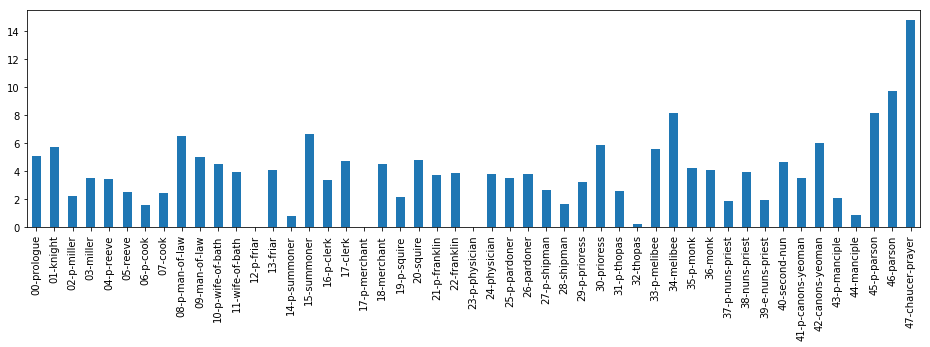

In [227]:
dfLangs['Latin'].plot(kind='bar', figsize=(16,4))

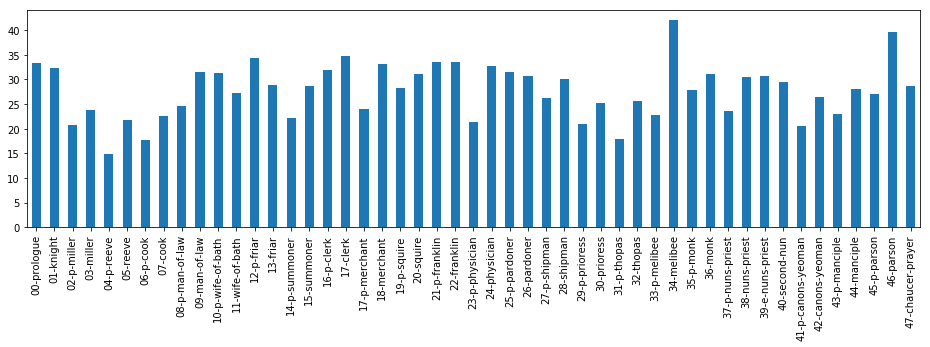

In [233]:
# All French
dfLangs[['Old French (842-ca. 1400)', 'Anglo-Norman', 'French']].sum(axis=1).plot(kind='bar', figsize=(16,4))

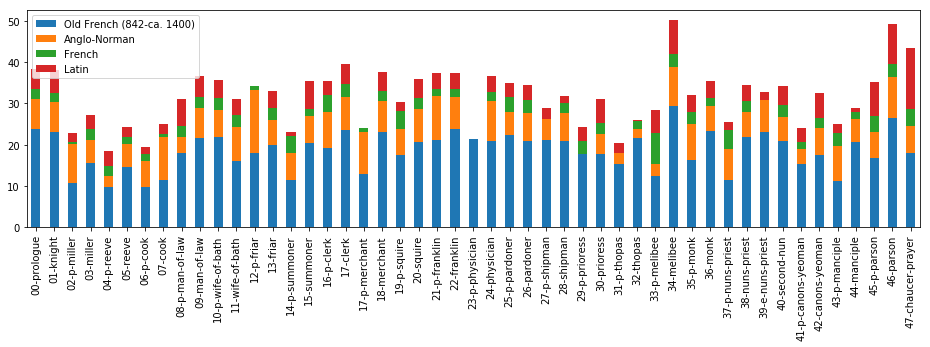

In [236]:
# All French
dfLangs[['Old French (842-ca. 1400)', 'Anglo-Norman', 'French', 'Latin']].plot(kind='bar', stacked=True, figsize=(16,4))

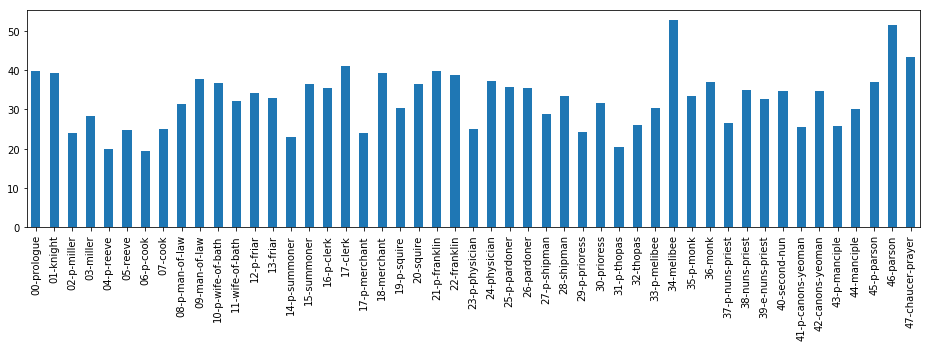

In [237]:
df['Latinate'].plot(kind='bar', figsize=(16, 4))

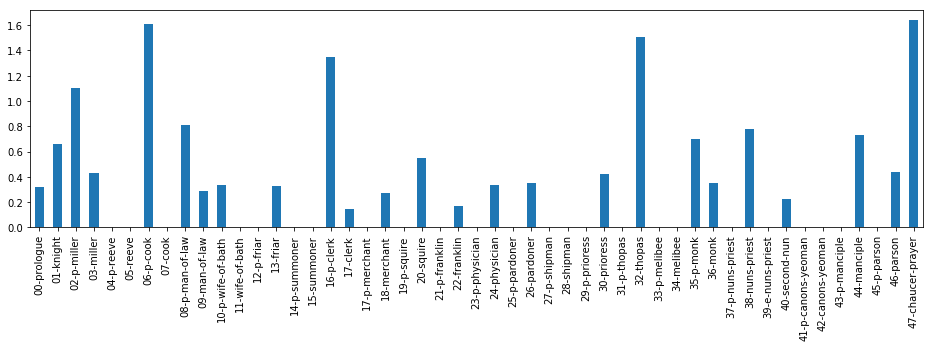

In [238]:
df['Hellenic'].plot(kind='bar', figsize=(16,4))

'THE Cook of London, while the Reeve thus spake, For joy he laugh\'d and clapp\'d him on the back: "Aha!" quoth he, "for Christes passion, This Miller had a sharp conclusion, Upon this argument of herbergage. Well saide Solomon in his language, Bring thou not every man into thine house, For harbouring by night is perilous. Well ought a man avised for to be Whom that he brought into his privity. I pray to God to give me sorrow and care If ever, since I highte Hodge of Ware, Heard I a miller better set a-work; He had a jape of malice in the derk. But God forbid that we should stinte here, And therefore if ye will vouchsafe to hear A tale of me, that am a poore man, I will you tell as well as e\'er I can A little jape that fell in our city." Our Host answer\'d and said; "I grant it thee. Roger, tell on; and look that it be good, For many a pasty hast thou letten blood, And many a Jack of Dover hast thou sold, That had been twice hot and twice cold. Of many a pilgrim hast thou Christe\'s c

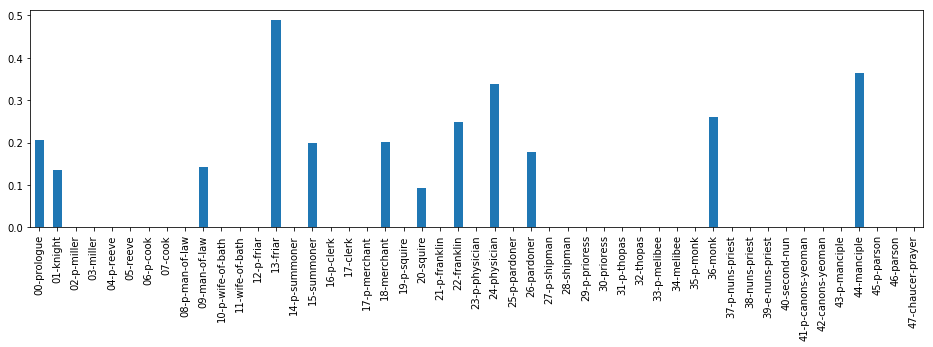

In [239]:
df['Celtic'].plot(kind='bar', figsize=(16,4))

In [240]:
texts = [Text(t, ignoreCurrent=False) for t in cleanTexts]
families = {filename: text.familyStats() for filename, text in zip(cleanFilenames, texts)}
langs = {filename: text.prettyStats for filename, text in zip(cleanFilenames, texts)}

In [241]:
dfFamilies = pd.DataFrame(families).T
dfLangs = pd.DataFrame(langs).T

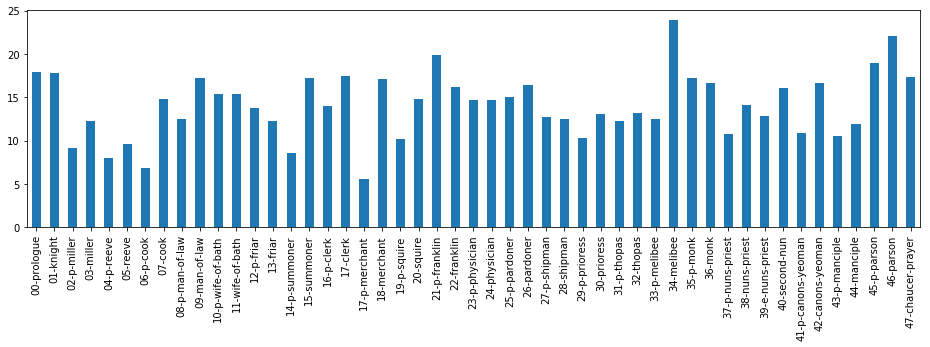

In [243]:
dfFamilies['Latinate'].plot(kind='bar', figsize=(16,4))

In [256]:
def isPrologue(row): 
    print(row)
    return True if '-p-' in row.index else False

In [263]:
dfFamilies['Prologue'] = dfFamilies.index.str.contains('-p-')

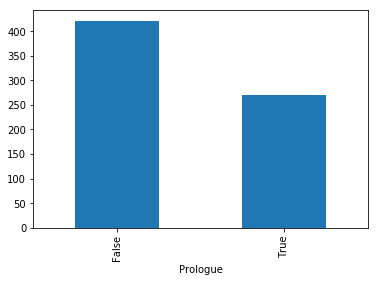

In [272]:
dfFamilies.groupby('Prologue')['Latinate'].sum().plot(kind='bar')